The code computes the timing of minima for eclipsing binaries based on user-provided ephemerides. This code is written for planning observation of The Eclipsing Binaries Minima (BIMA) 2.0 Monitoring Project.

- Code 1 is used when the initial epoch or last known time of minima in Heliocentric Julian Date (HJD)
- Code 2 is used when the initial epoch or last known time of minima in Julian Date (JD)

The code will compute next time of primary minima during any given observing time and create plot of simplified light curve (assumed as sinusoidal; the secondary minima is at phase 0.5 or shown as maxima on the graphs). The time of minima (primary minima) and maxima (secondary minima) are shown on the graphs.

The user need to give input as csv data table with column defined as:
- column 1: Object ID (e.g., RT And')
- column 2: Right Ascension (hhmmss.sss format, e.g., 23h11m10.01s)
- column 3: Declination (ddmmss.sss format, e.g., 53d01m33.0s)
- column 4: Initial epoch (in HJD, e.g., 2452500.3476)
- column 5: Period (in days, e.g., 0.628929)

The code also take observer location and observation window (in local time) from user input
Enter observer location:
Latitude (deg, -90 to 90 , e.g. -6.8245):  
Longitude (deg, -180 to 180, e.g. 107.6159):  
Altitude (m): 
Timezone offset (hrs from UTC, e.g., -4 for EDT): 

Enter observation window (local time):
Start (YYYYMMDD HHMM, e.g., 20240515 2100):  
End (YYYYMMDD HHMM, e.g., 20240516 0300): 

### 1. Calculate time of minima if the initial epoch in Heliocentric Julian Date (HJD)

Binary Star Ephemeris Calculator




Enter the name of the input CSV file (e.g., 'object_list.csv'):  object_list.csv



Enter observer location:


Latitude (deg, -90 to 90, e.g. -6.8245):  -6.8245
Longitude (deg, -180 to 180, e.g. 107.6159):  107.6159
Altitude (m):  1310
Timezone offset (hours from UTC, e.g. 7 for Jakarta):  7



Enter observation window (local time):


Start (YYYYMMDD HHMM, e.g., 20240515 2100):  20250620 1100
End (YYYYMMDD HHMM, e.g., 20240516 0300):  20250624 0500



Calculated Minima:
Object  Epoch             JD            HJD          Local_Time
RT And  13270 2460846.236558 2460846.237837 2025-06-20 00:40:38
RT And  13271 2460846.865487 2460846.866731 2025-06-20 15:46:18
RT And  13272 2460847.494416 2460847.495624 2025-06-21 06:51:57
RT And  13273 2460848.123345 2460848.124517 2025-06-21 21:57:37
RT And  13274 2460848.752275 2460848.753410 2025-06-22 13:03:16
RT And  13275 2460849.381204 2460849.382303 2025-06-23 04:08:56
RT And  13276 2460850.010133 2460850.011196 2025-06-23 19:14:35
SY And    238 2460839.039136 2460839.041581 2025-06-12 19:56:21
TT And   3017 2460846.178192 2460846.179240 2025-06-19 23:16:35
TT And   3018 2460848.943288 2460848.944154 2025-06-22 17:38:20
TW And   2023 2460846.279607 2460846.281077 2025-06-20 01:42:38
TW And   2025 2460850.402335 2460850.403467 2025-06-24 04:39:21

Results saved to 'minima_table.csv'


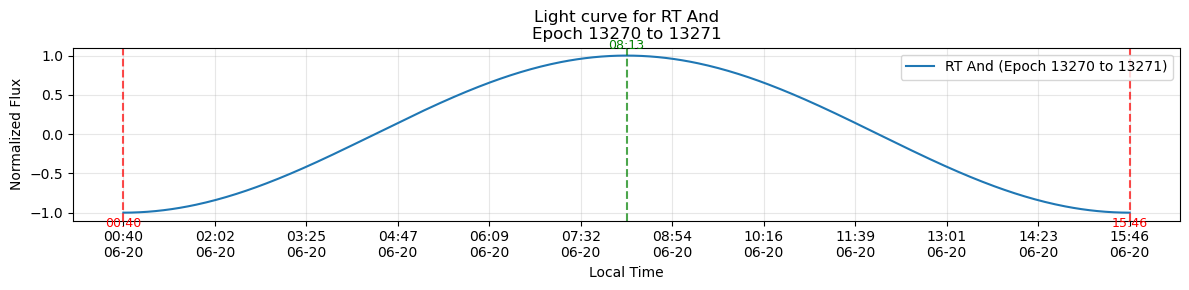

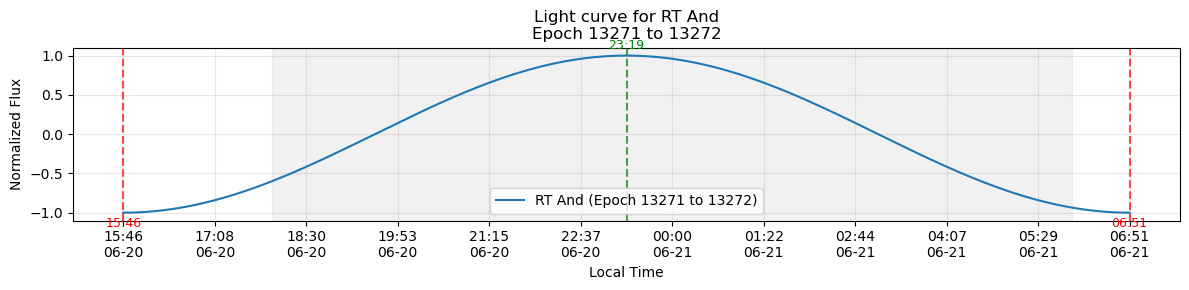

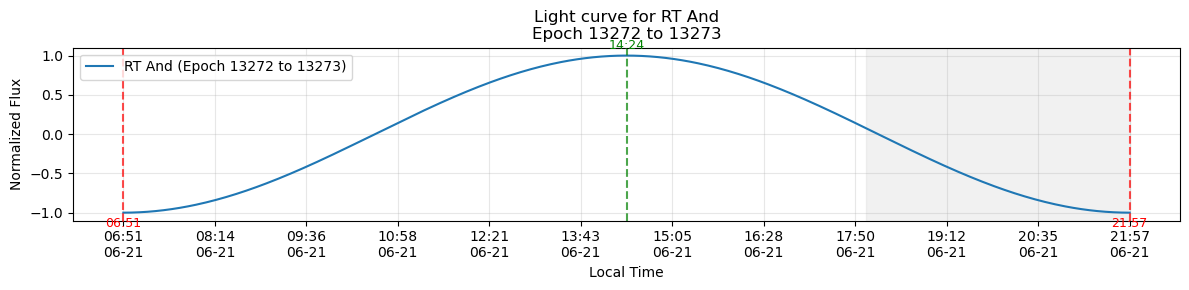

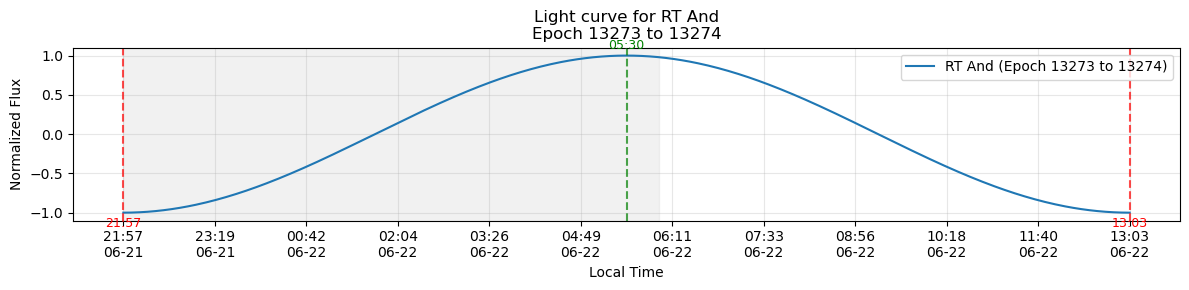

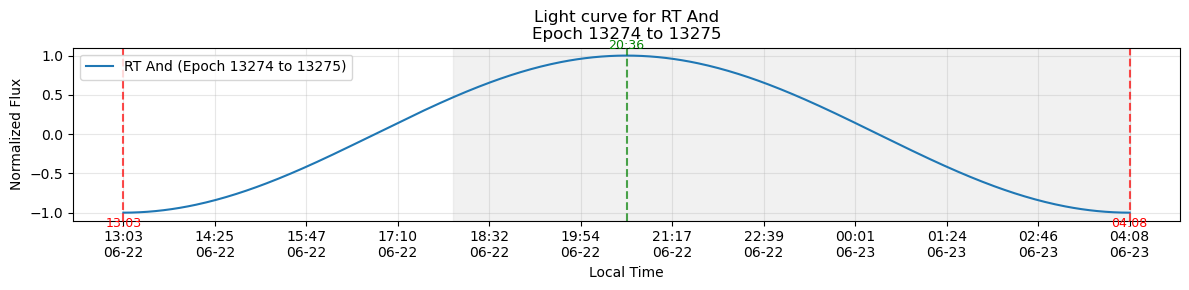

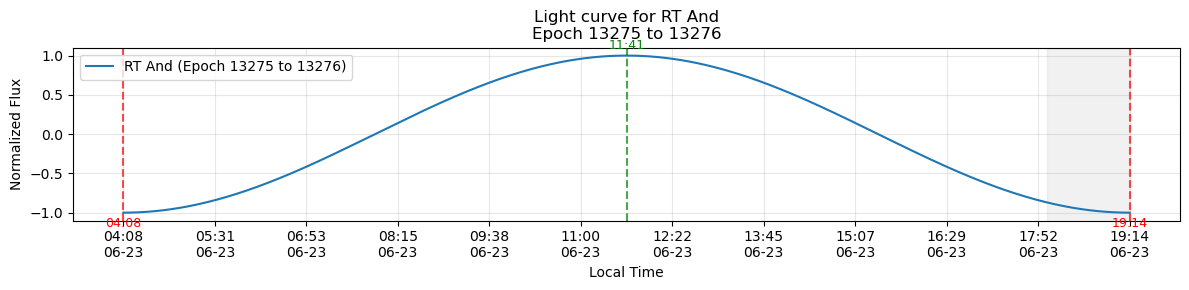

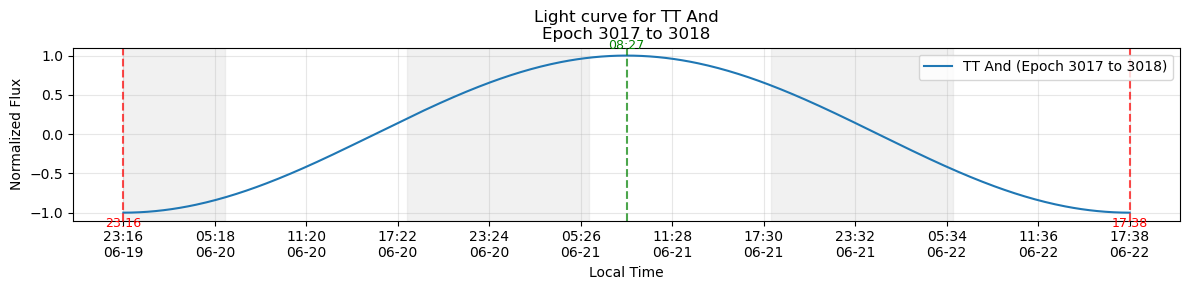

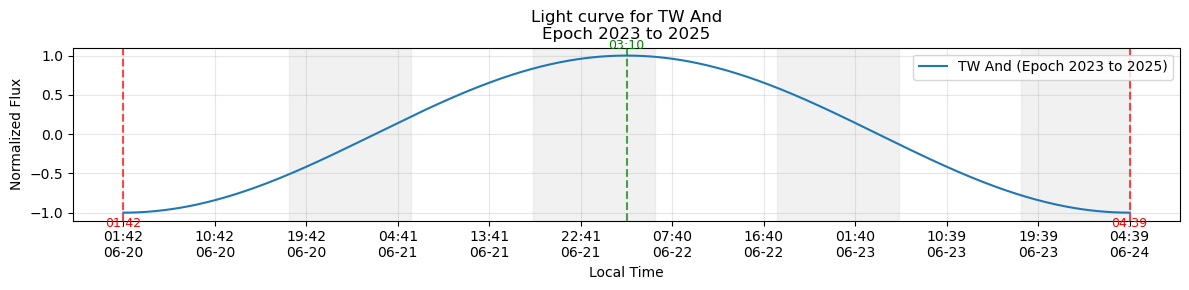

In [27]:
import pandas as pd
from astropy import time, coordinates as coord, units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter, HourLocator
import datetime

def hjd_to_jd(hjd, tcoord, obs_location):
    """Convert HJD to JD with light-time correction"""
    t_hjd = Time(hjd, format='jd', scale='utc')
    ltt = t_hjd.light_travel_time(tcoord, 'heliocentric', location=obs_location)
    return (t_hjd - ltt).jd

def get_observer_location():
    """Get observer location with validation"""
    print("\nEnter observer location:")
    while True:
        try:
            lat = float(input("Latitude (deg, -90 to 90, e.g. -6.8245): "))
            if not -90 <= lat <= 90:
                raise ValueError("Latitude must be between -90 and 90")
            lon = float(input("Longitude (deg, -180 to 180, e.g. 107.6159): "))
            if not -180 <= lon <= 180:
                raise ValueError("Longitude must be between -180 and 180")
            alt = float(input("Altitude (m): "))
            tz_offset = float(input("Timezone offset (hours from UTC, e.g. 7 for Jakarta): "))
            break
        except ValueError as e:
            print(f"Invalid input: {e}")
    
    return EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m), tz_offset

def get_observation_window(tz_offset):
    """Get observation window with validation"""
    print("\nEnter observation window (local time):")
    while True:
        try:
            start_str = input("Start (YYYYMMDD HHMM, e.g., 20240515 2100): ").strip()
            end_str = input("End (YYYYMMDD HHMM, e.g., 20240516 0300): ").strip()
            
            if len(start_str) != 13 or len(end_str) != 13:
                raise ValueError("Date format must be YYYYMMDD HHMM")
            
            start_iso = f"{start_str[:4]}-{start_str[4:6]}-{start_str[6:8]}T{start_str[9:11]}:{start_str[11:13]}:00"
            end_iso = f"{end_str[:4]}-{end_str[4:6]}-{end_str[6:8]}T{end_str[9:11]}:{end_str[11:13]}:00"
            
            start_utc = Time(start_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            end_utc = Time(end_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            
            if end_utc <= start_utc:
                raise ValueError("End time must be after start time")
            
            return start_utc, end_utc
        except Exception as e:
            print(f"Error in dates: {e}")

def calculate_minima(objects_df, obs_location, tz_offset, start_utc, end_utc):
    """Calculate all minima within observation window"""
    minima_data = []
    
    for _, row in objects_df.iterrows():
        e0_jd = hjd_to_jd(row['e0hjd'], row['tcoord'], obs_location)
        period = row['period']
        ep_start = int((start_utc.jd - e0_jd) / period)
        tmin = e0_jd + max(0, ep_start) * period
        
        while tmin <= end_utc.jd:
            tmin_utc = Time(tmin, format='jd', scale='utc')
            tmin_local = tmin_utc.to_datetime() + pd.Timedelta(hours=tz_offset)
            epoch = int((tmin - e0_jd) / period)
            
            minima_data.append({
                'Object': row['id'],
                'Epoch': epoch,
                'JD': tmin,
                'HJD': hjd_to_jd(tmin, row['tcoord'], obs_location),
                'Local_Time': tmin_local.strftime('%Y-%m-%d %H:%M:%S'),
                'Period': period
            })
            tmin += period
        
    return pd.DataFrame(minima_data)

def plot_light_curves(minima_df, tz_offset):
    """Generate plots with nighttime shading and exactly 12 x-axis ticks"""
    if minima_df.empty:
        print("No minima found to plot!")
        return
    
    for (obj, group) in minima_df.groupby('Object'):
        if len(group) < 2:
            print(f"Warning: Only one minimum found for {obj}, cannot plot light curve")
            continue
            
        for i in range(len(group)-1):
            row1 = group.iloc[i]
            row2 = group.iloc[i+1]
            
            fig, ax = plt.subplots(figsize=(12, 3))
            
            # Generate light curve
            jd_range = np.linspace(row1['JD'], row2['JD'], 500)
            phases = ((jd_range - row1['JD']) / row1['Period']) % 1
            flux = -np.cos(2 * np.pi * phases)
            
            # Convert to local datetime
            times = [Time(jd, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset) 
                    for jd in jd_range]
            
            # Check if times is empty
            if not times:
                print(f"No valid times for object {obj}. Skipping plot.")
                continue
            
            # Plot curve
            ax.plot(times, flux, label=f"{obj} (Epoch {row1['Epoch']} to {row2['Epoch']})")
            
            # Add nighttime shading (18:00-06:00)
            start_date = times[0].date()
            end_date = times[-1].date()
            current_date = start_date
            
            while current_date <= end_date:
                night_start = datetime.datetime.combine(current_date, datetime.time(18, 0))
                night_end = datetime.datetime.combine(current_date + datetime.timedelta(days=1), datetime.time(6, 0))
                
                if times[-1] > night_start and times[0] < night_end:
                    ax.axvspan(max(night_start, times[0]), min(night_end, times[-1]), 
                              color='lightgray', alpha=0.3)
                
                current_date += datetime.timedelta(days=1)
            
            # Mark minima and maxima
            min1_time = Time(row1['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            min2_time = Time(row2['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            max_time = Time((row1['JD'] + row2['JD'])/2, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            
            ax.axvline(x=min1_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min1_time, -1.05, min1_time.strftime('%H:%M'), ha='center', va='top', color='r', fontsize=9)
            
            ax.axvline(x=min2_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min2_time, -1.05, min2_time.strftime('%H:%M'), ha='center', va='top', color='r', fontsize=9)
            
            ax.axvline(x=max_time, color='g', linestyle='--', alpha=0.7)
            ax.text(max_time, 1.05, max_time.strftime('%H:%M'), ha='center', va='bottom', color='g', fontsize=9)
            
            # Format plot with exactly 12 ticks on x-axis
            ax.set_title(f"Light curve for {obj}\nEpoch {row1['Epoch']} to {row2['Epoch']}")
            ax.set_xlabel("Local Time")
            ax.set_ylabel("Normalized Flux")
            ax.set_ylim(-1.1, 1.1)
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
            
            # Calculate exactly 12 evenly spaced ticks
            min_time = min(times)
            max_time = max(times)
            time_delta = (max_time - min_time) / 11  # 11 intervals = 12 ticks
            ticks = [min_time + i * time_delta for i in range(12)]
            ax.set_xticks(ticks)
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M\n%m-%d'))
            
            ax.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

def get_input_filename():
    """Prompt user for input CSV filename"""
    while True:
        filename = input("\nEnter the name of the input CSV file (e.g., 'object_list.csv'): ").strip()
        if not filename:
            print("Please enter a filename.")
            continue
        if not filename.lower().endswith('.csv'):
            filename += '.csv'
        return filename

def main():
    print("Binary Star Ephemeris Calculator")
    print("===============================\n")
    
    # Get input filename from user
    input_filename = get_input_filename()
    
    # Load object list
    try:
        objects_df = pd.read_csv(input_filename)
        required_cols = ['id', 'ra', 'dec', 'e0hjd', 'period']
        if not all(col in objects_df.columns for col in required_cols):
            raise ValueError("CSV must contain columns: id, ra, dec, e0hjd, period")
        
        # Create SkyCoord objects
        objects_df['tcoord'] = objects_df.apply(
            lambda row: coord.SkyCoord(row['ra'], row['dec']), axis=1)
    except Exception as e:
        print(f"Error loading object list: {e}")
        return
    
    # Get observer info
    obs_location, tz_offset = get_observer_location()
    start_utc, end_utc = get_observation_window(tz_offset)
    
    # Calculate minima
    minima_df = calculate_minima(objects_df, obs_location, tz_offset, start_utc, end_utc)
    
    if minima_df.empty:
        print("\nNo minima found in the specified observation window!")
        return
    
    # Display and save results
    print("\nCalculated Minima:")
    print("=================")
    with pd.option_context('display.float_format', '{:.6f}'.format):
        print(minima_df[['Object', 'Epoch', 'JD', 'HJD', 'Local_Time']].to_string(index=False))
    
    minima_df.to_csv('minima_table.csv', index=False, float_format='%.6f')
    print(f"\nResults saved to 'minima_table.csv'")
    
    # Plot light curves
    plot_light_curves(minima_df, tz_offset)

if __name__ == "__main__":
    main()


### 2. Calculate time of minima if the initial epoch in Julian Date (JD)

Binary Star Ephemeris Calculator (JD version)




Enter the name of the input CSV file (default: object_list_jd.csv):  object_list_jd.csv



Enter observer location:


Latitude (deg, -90 to 90, e.g. -6.8245):  -6.8245
Longitude (deg, -180 to 180, e.g. 107.6159):  107.6159
Altitude (m):  1310
Timezone offset (hours from UTC, e.g. 7 for Jakarta):  7



Enter observation window (local time):


Start (YYYYMMDD HHMM, e.g., 20240515 2100):  20250620 1100
End (YYYYMMDD HHMM, e.g., 20240516 0300):  20250624 0500



Calculated Minima:
Object  Epoch             JD          Local_Time
RT And  13270 2460846.238484 2025-06-20 00:43:25
RT And  13271 2460846.867413 2025-06-20 15:49:04
RT And  13272 2460847.496342 2025-06-21 06:54:43
RT And  13273 2460848.125272 2025-06-21 22:00:23
RT And  13274 2460848.754201 2025-06-22 13:06:02
RT And  13275 2460849.383130 2025-06-23 04:11:42
RT And  13276 2460850.012059 2025-06-23 19:17:21
SY And    238 2460839.042960 2025-06-12 20:01:51
TT And   3017 2460846.180728 2025-06-19 23:20:14
TT And   3018 2460848.945824 2025-06-22 17:41:59
TW And   2023 2460846.282686 2025-06-20 01:47:04
TW And   2025 2460850.405415 2025-06-24 04:43:47

Results saved to 'minima_table.csv'


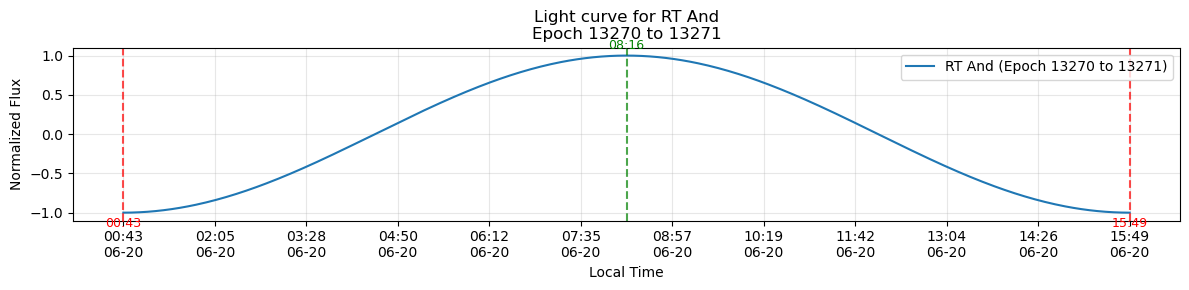

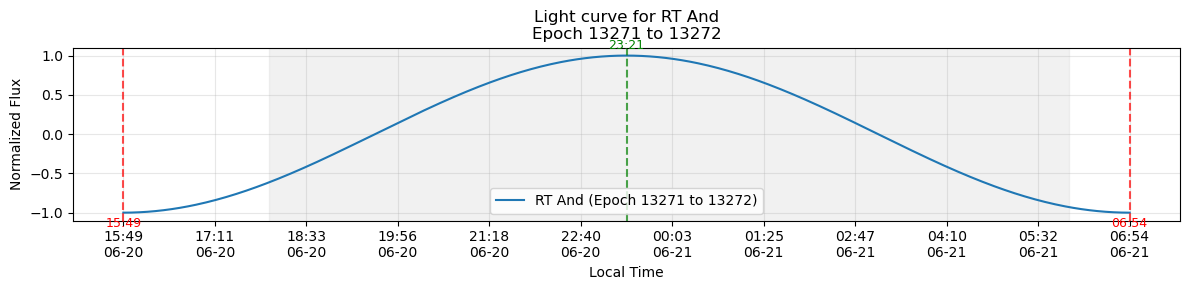

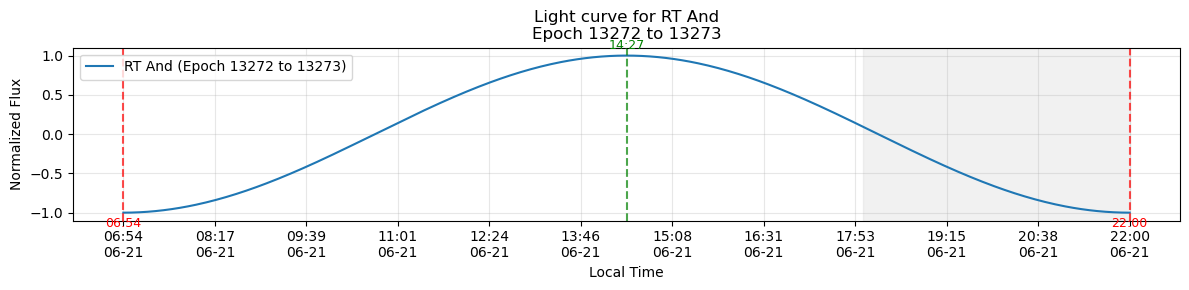

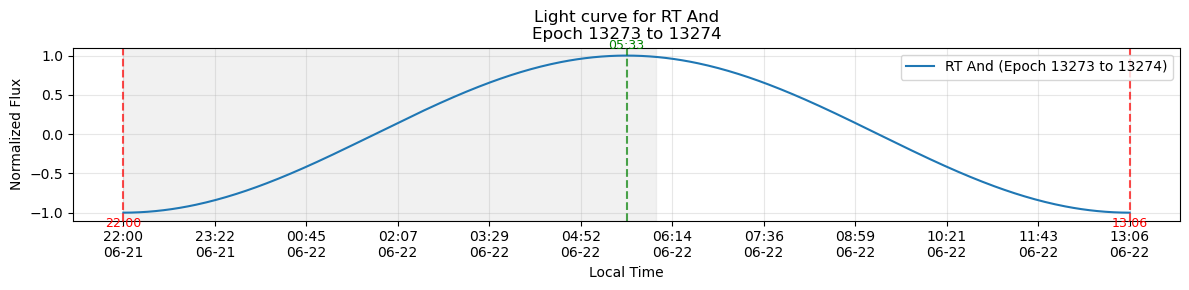

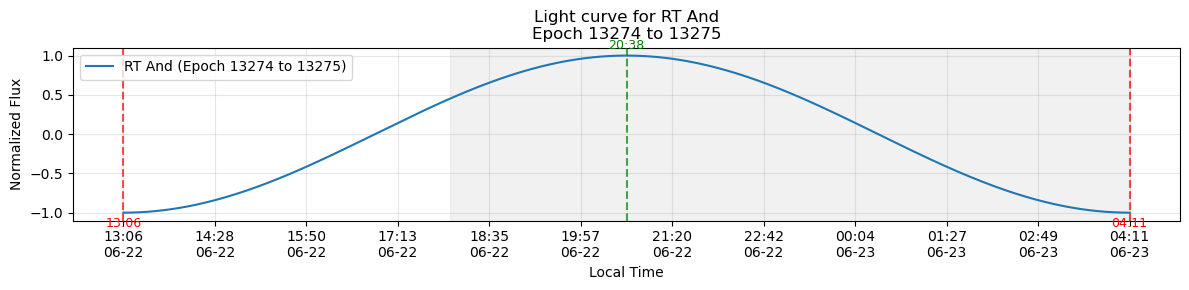

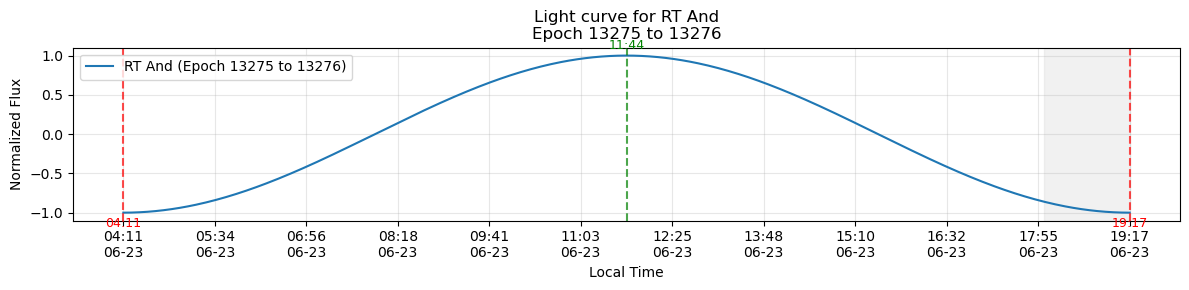

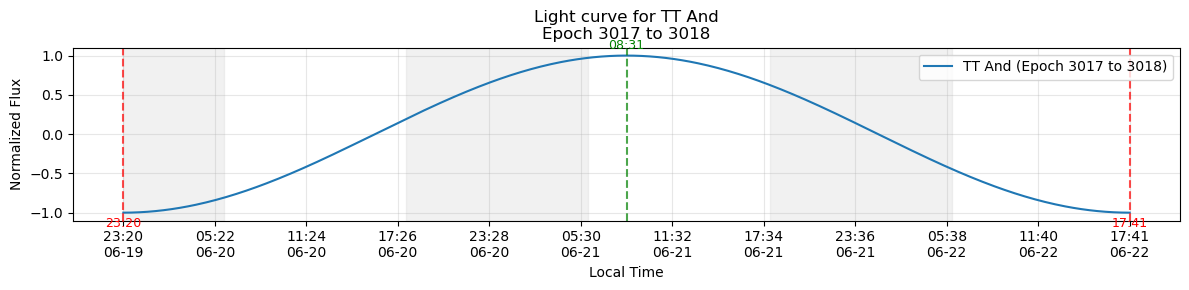

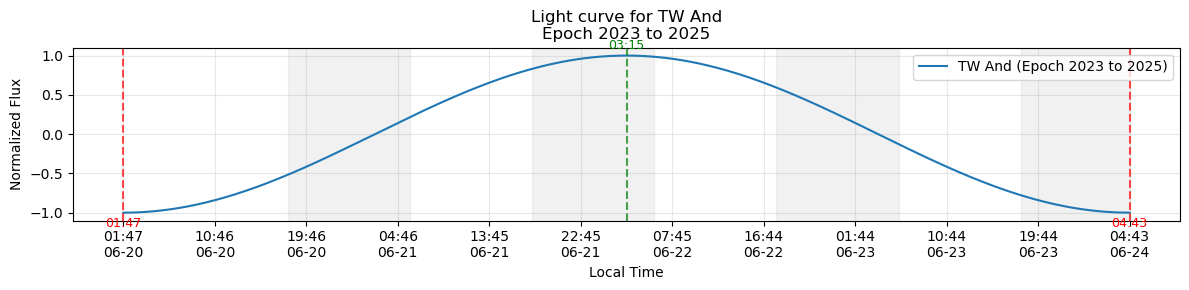

In [29]:
import pandas as pd
from astropy import time, coordinates as coord, units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import EarthLocation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter, HourLocator
import datetime

def get_observer_location():
    """Get observer location with validation"""
    print("\nEnter observer location:")
    while True:
        try:
            lat = float(input("Latitude (deg, -90 to 90, e.g. -6.8245): "))
            if not -90 <= lat <= 90:
                raise ValueError("Latitude must be between -90 and 90")
            lon = float(input("Longitude (deg, -180 to 180, e.g. 107.6159): "))
            if not -180 <= lon <= 180:
                raise ValueError("Longitude must be between -180 and 180")
            alt = float(input("Altitude (m): "))
            tz_offset = float(input("Timezone offset (hours from UTC, e.g. 7 for Jakarta): "))
            break
        except ValueError as e:
            print(f"Invalid input: {e}")
    
    return EarthLocation(lat=lat*u.deg, lon=lon*u.deg, height=alt*u.m), tz_offset

def get_observation_window(tz_offset):
    """Get observation window with validation"""
    print("\nEnter observation window (local time):")
    while True:
        try:
            start_str = input("Start (YYYYMMDD HHMM, e.g., 20240515 2100): ").strip()
            end_str = input("End (YYYYMMDD HHMM, e.g., 20240516 0300): ").strip()
            
            if len(start_str) != 13 or len(end_str) != 13:
                raise ValueError("Date format must be YYYYMMDD HHMM")
            
            start_iso = f"{start_str[:4]}-{start_str[4:6]}-{start_str[6:8]}T{start_str[9:11]}:{start_str[11:13]}:00"
            end_iso = f"{end_str[:4]}-{end_str[4:6]}-{end_str[6:8]}T{end_str[9:11]}:{end_str[11:13]}:00"
            
            start_utc = Time(start_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            end_utc = Time(end_iso, format='isot', scale='utc') - TimeDelta(tz_offset*3600, format='sec')
            
            if end_utc <= start_utc:
                raise ValueError("End time must be after start time")
            
            return start_utc, end_utc
        except Exception as e:
            print(f"Error in dates: {e}")

def calculate_minima(objects_df, obs_location, tz_offset, start_utc, end_utc):
    """Calculate all minima within observation window"""
    minima_data = []
    
    for _, row in objects_df.iterrows():
        e0_jd = row['e0jd']  # Directly use JD without light-time correction
        period = row['period']
        ep_start = int((start_utc.jd - e0_jd) / period)
        tmin = e0_jd + max(0, ep_start) * period
        
        while tmin <= end_utc.jd:
            tmin_utc = Time(tmin, format='jd', scale='utc')
            tmin_local = tmin_utc.to_datetime() + pd.Timedelta(hours=tz_offset)
            epoch = int((tmin - e0_jd) / period)
            
            minima_data.append({
                'Object': row['id'],
                'Epoch': epoch,
                'JD': tmin,
                'Local_Time': tmin_local.strftime('%Y-%m-%d %H:%M:%S'),
                'Period': period
            })
            tmin += period
        
    return pd.DataFrame(minima_data)

def plot_light_curves(minima_df, tz_offset):
    """Generate plots with nighttime shading and exactly 12 x-axis ticks"""
    if minima_df.empty:
        print("No minima found to plot!")
        return
    
    for (obj, group) in minima_df.groupby('Object'):
        if len(group) < 2:
            print(f"Warning: Only one minimum found for {obj}, cannot plot light curve")
            continue
            
        for i in range(len(group)-1):
            row1 = group.iloc[i]
            row2 = group.iloc[i+1]
            
            fig, ax = plt.subplots(figsize=(12, 3))
            
            # Generate light curve
            jd_range = np.linspace(row1['JD'], row2['JD'], 500)
            phases = ((jd_range - row1['JD']) / row1['Period']) % 1
            flux = -np.cos(2 * np.pi * phases)
            
            # Convert to local datetime
            times = [Time(jd, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset) 
                    for jd in jd_range]
            
            if not times:
                print(f"No valid times for object {obj}. Skipping plot.")
                continue
            
            # Plot curve
            ax.plot(times, flux, label=f"{obj} (Epoch {row1['Epoch']} to {row2['Epoch']})")
            
            # Add nighttime shading (18:00-06:00)
            start_date = times[0].date()
            end_date = times[-1].date()
            current_date = start_date
            
            while current_date <= end_date:
                night_start = datetime.datetime.combine(current_date, datetime.time(18, 0))
                night_end = datetime.datetime.combine(current_date + datetime.timedelta(days=1), datetime.time(6, 0))
                
                if times[-1] > night_start and times[0] < night_end:
                    ax.axvspan(max(night_start, times[0]), min(night_end, times[-1]), 
                              color='lightgray', alpha=0.3)
                
                current_date += datetime.timedelta(days=1)
            
            # Mark minima and maxima
            min1_time = Time(row1['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            min2_time = Time(row2['JD'], format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            max_time = Time((row1['JD'] + row2['JD'])/2, format='jd').to_datetime() + pd.Timedelta(hours=tz_offset)
            
            ax.axvline(x=min1_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min1_time, -1.05, min1_time.strftime('%H:%M'), ha='center', va='top', color='r', fontsize=9)
            
            ax.axvline(x=min2_time, color='r', linestyle='--', alpha=0.7)
            ax.text(min2_time, -1.05, min2_time.strftime('%H:%M'), ha='center', va='top', color='r', fontsize=9)
            
            ax.axvline(x=max_time, color='g', linestyle='--', alpha=0.7)
            ax.text(max_time, 1.05, max_time.strftime('%H:%M'), ha='center', va='bottom', color='g', fontsize=9)
            
            # Format plot with exactly 12 ticks on x-axis
            ax.set_title(f"Light curve for {obj}\nEpoch {row1['Epoch']} to {row2['Epoch']}")
            ax.set_xlabel("Local Time")
            ax.set_ylabel("Normalized Flux")
            ax.set_ylim(-1.1, 1.1)
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
            
            # Calculate exactly 12 evenly spaced ticks
            min_time = min(times)
            max_time = max(times)
            time_delta = (max_time - min_time) / 11  # 11 intervals = 12 ticks
            ticks = [min_time + i * time_delta for i in range(12)]
            ax.set_xticks(ticks)
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M\n%m-%d'))
            
            ax.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

def get_input_filename():
    """Prompt user for input CSV filename with default suggestion"""
    default_filename = "object_list_jd.csv"
    while True:
        filename = input(f"\nEnter the name of the input CSV file (default: {default_filename}): ").strip()
        if not filename:
            filename = default_filename
        if not filename.lower().endswith('.csv'):
            filename += '.csv'
        return filename

def main():
    print("Binary Star Ephemeris Calculator (JD version)")
    print("===========================================\n")
    
    # Get input filename from user
    input_filename = get_input_filename()
    
    # Load object list
    try:
        objects_df = pd.read_csv(input_filename)
        required_cols = ['id', 'ra', 'dec', 'e0jd', 'period']  # Changed e0hjd to e0jd
        if not all(col in objects_df.columns for col in required_cols):
            raise ValueError(f"CSV must contain columns: {', '.join(required_cols)}")
        
        # Create SkyCoord objects
        objects_df['tcoord'] = objects_df.apply(
            lambda row: coord.SkyCoord(row['ra'], row['dec']), axis=1)
    except Exception as e:
        print(f"Error loading object list: {e}")
        return
    
    # Get observer info
    obs_location, tz_offset = get_observer_location()
    start_utc, end_utc = get_observation_window(tz_offset)
    
    # Calculate minima
    minima_df = calculate_minima(objects_df, obs_location, tz_offset, start_utc, end_utc)
    
    if minima_df.empty:
        print("\nNo minima found in the specified observation window!")
        return
    
    # Display and save results
    print("\nCalculated Minima:")
    print("=================")
    with pd.option_context('display.float_format', '{:.6f}'.format):
        print(minima_df[['Object', 'Epoch', 'JD', 'Local_Time']].to_string(index=False))
    
    minima_df.to_csv('minima_table.csv', index=False, float_format='%.6f')
    print(f"\nResults saved to 'minima_table.csv'")
    
    # Plot light curves
    plot_light_curves(minima_df, tz_offset)

if __name__ == "__main__":
    main()
